In [3]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import tqdm
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

from collections import OrderedDict
import cv2

In [4]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [5]:
!pip install --upgrade pip

  Using cached pip-23.3.1-py3-none-any.whl.metadata (3.5 kB)
Using cached pip-23.3.1-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
C:\Users\user\anaconda3\envs\1019\python.exe -m pip install --upgrade pip


In [6]:
!pip install pretrainedmodels > /dev/null

지정된 경로를 찾을 수 없습니다.


In [7]:
import pretrainedmodels

In [8]:
train_df = pd.read_csv("./whale-categorization-playground/train.csv")
train_df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [9]:
print(f"There are {len(os.listdir('./whale-categorization-playground/train'))} images in train dataset with {train_df.Id.nunique()} unique classes.")
print(f"There are {len(os.listdir('./whale-categorization-playground/test'))} images in test dataset.")

There are 9850 images in train dataset with 4251 unique classes.
There are 15610 images in test dataset.


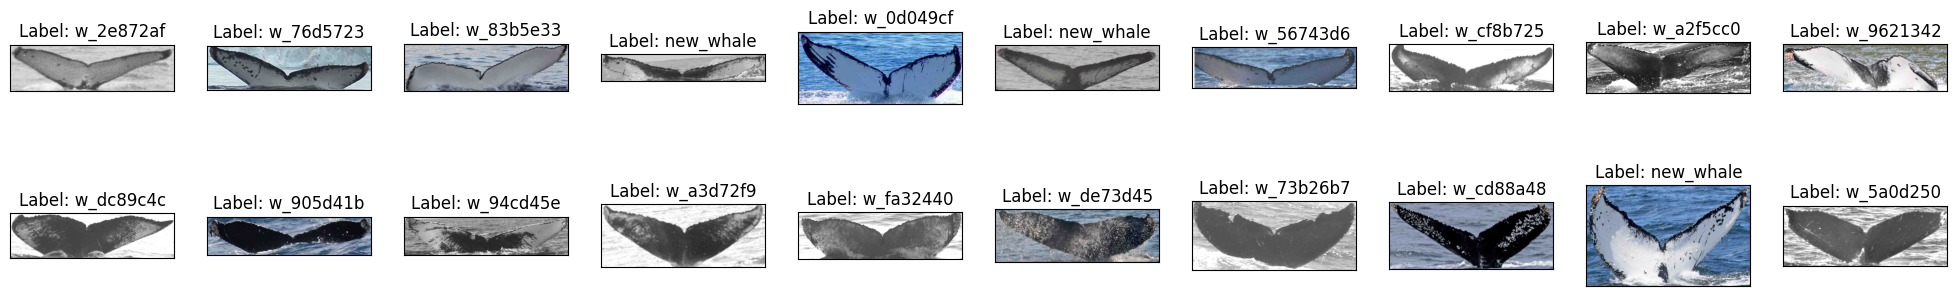

In [10]:
fig = plt.figure(figsize=(25, 4))
train_imgs = os.listdir("./whale-categorization-playground/train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("./whale-categorization-playground/train/" + img)
    plt.imshow(im)
    lab = train_df.loc[train_df.Image == img, 'Id'].values[0]
    ax.set_title(f'Label: {lab}')

In [11]:
train_df.Id.value_counts().head()

Id
new_whale    810
w_1287fbc     34
w_98baff9     27
w_7554f44     26
w_1eafe46     23
Name: count, dtype: int64

In [12]:
for i in range(1, 4):
    print(f'There are {train_df.Id.value_counts()[train_df.Id.value_counts().values==i].shape[0]} classes with {i} samples in train data.')

There are 2220 classes with 1 samples in train data.
There are 1034 classes with 2 samples in train data.
There are 492 classes with 3 samples in train data.


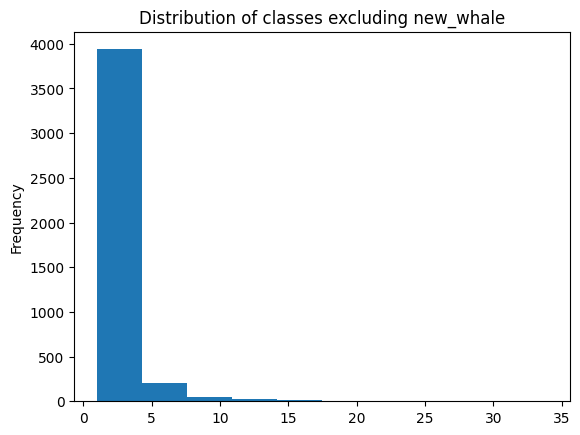

In [13]:
plt.title('Distribution of classes excluding new_whale');
train_df.Id.value_counts()[1:].plot(kind='hist');

In [14]:
np.array(im).shape

(337, 928, 3)

In [15]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

data_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=18, p=0.5),
    A.Affine(shear=0.4, p=0.5),  
    
    A.ToGray(p=0.4),

    A.OneOf([
        A.GaussianBlur(blur_limit=3, p=1.0),
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, p=1.0)
    ], p=0.5),

    # A.OneOf([
    #     A.PiecewiseAffine(scale=(0.01, 0.03), p=1.0),
    #     A.Perspective(p=1.0),
    # ], p=0.5),

    A.HorizontalFlip(p=0.5),
    
    ToTensorV2(),
])

C:\Users\user\anaconda3\envs\1019\Lib\site-packages\albumentations\augmentations\blur\transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


In [16]:
data_transforms_test = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [17]:
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

In [18]:
y, le = prepare_labels(train_df['Id'])

C:\Users\user\anaconda3\envs\1019\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform=None, y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform

    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx][0])
            label = self.y[idx]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx])
            label = np.zeros((4251,))

        image = Image.open(img_name).convert('RGB')
        image = np.array(image)  # PIL 이미지를 numpy 배열로 변환
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            return image, label, self.image_files_list[idx]

In [20]:
train_dataset = WhaleDataset(datafolder='./whale-categorization-playground/train/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='./whale-categorization-playground/test/', datatype='test', transform=data_transforms_test)

In [21]:
train_sampler = SubsetRandomSampler(list(range(len(os.listdir('./whale-categorization-playground/train/')))))
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('./whale-categorization-playground/test/')))))
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
# less size for test loader.
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=num_workers)

In [22]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [23]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [25]:
model_conv = pretrainedmodels.resnet101()
model_conv.last_linear = nn.Linear(model_conv.last_linear.in_features, 4251)
print(model_conv)
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model_conv.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch
import tqdm
import numpy as np
import time

model_conv = model_conv.cuda()
n_epochs = 80
best_train_loss = float('inf') 

for epoch in range(1, n_epochs + 1):
    print(time.ctime(), 'Epoch:', epoch)

    model_conv.train()
    train_loss = []
    for data, target in tqdm.tqdm(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model_conv(data)
        loss = criterion(output, target.float())
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    avg_train_loss = np.mean(train_loss)
    print(f'Epoch {epoch}, Train Loss: {avg_train_loss:.4f}')
    
    torch.save(model_conv.state_dict(), 'base_resnet101.pt')

    if avg_train_loss <= best_train_loss:
        best_train_loss = avg_train_loss
        torch.save(model_conv.state_dict(), 'best_resnet101.pt')
        print("Best model saved with train loss: {:.4f}".format(avg_train_loss))

Tue Dec  5 19:30:21 2023 Epoch: 1


100%|██████████| 154/154 [01:29<00:00,  1.73it/s]


Epoch 1, Train Loss: 0.0105
Best model saved with train loss: 0.0105
Tue Dec  5 19:31:51 2023 Epoch: 2


100%|██████████| 154/154 [01:15<00:00,  2.03it/s]


Epoch 2, Train Loss: 0.0021
Best model saved with train loss: 0.0021
Tue Dec  5 19:33:07 2023 Epoch: 3


100%|██████████| 154/154 [01:10<00:00,  2.20it/s]


Epoch 3, Train Loss: 0.0021
Tue Dec  5 19:34:18 2023 Epoch: 4


100%|██████████| 154/154 [01:12<00:00,  2.13it/s]


Epoch 4, Train Loss: 0.0021
Best model saved with train loss: 0.0021
Tue Dec  5 19:35:31 2023 Epoch: 5


100%|██████████| 154/154 [01:06<00:00,  2.30it/s]


Epoch 5, Train Loss: 0.0021
Best model saved with train loss: 0.0021
Tue Dec  5 19:36:38 2023 Epoch: 6


100%|██████████| 154/154 [01:07<00:00,  2.27it/s]


Epoch 6, Train Loss: 0.0021
Best model saved with train loss: 0.0021
Tue Dec  5 19:37:47 2023 Epoch: 7


100%|██████████| 154/154 [01:07<00:00,  2.30it/s]


Epoch 7, Train Loss: 0.0020
Best model saved with train loss: 0.0020
Tue Dec  5 19:38:55 2023 Epoch: 8


100%|██████████| 154/154 [01:09<00:00,  2.23it/s]


Epoch 8, Train Loss: 0.0020
Best model saved with train loss: 0.0020
Tue Dec  5 19:40:04 2023 Epoch: 9


100%|██████████| 154/154 [01:07<00:00,  2.29it/s]


Epoch 9, Train Loss: 0.0020
Best model saved with train loss: 0.0020
Tue Dec  5 19:41:12 2023 Epoch: 10


100%|██████████| 154/154 [01:07<00:00,  2.28it/s]


Epoch 10, Train Loss: 0.0020
Best model saved with train loss: 0.0020
Tue Dec  5 19:42:20 2023 Epoch: 11


100%|██████████| 154/154 [01:07<00:00,  2.27it/s]


Epoch 11, Train Loss: 0.0019
Best model saved with train loss: 0.0019
Tue Dec  5 19:43:29 2023 Epoch: 12


100%|██████████| 154/154 [01:07<00:00,  2.30it/s]


Epoch 12, Train Loss: 0.0019
Best model saved with train loss: 0.0019
Tue Dec  5 19:44:36 2023 Epoch: 13


100%|██████████| 154/154 [01:03<00:00,  2.43it/s]


Epoch 13, Train Loss: 0.0018
Best model saved with train loss: 0.0018
Tue Dec  5 19:45:40 2023 Epoch: 14


100%|██████████| 154/154 [01:01<00:00,  2.49it/s]


Epoch 14, Train Loss: 0.0018
Best model saved with train loss: 0.0018
Tue Dec  5 19:46:43 2023 Epoch: 15


100%|██████████| 154/154 [01:03<00:00,  2.43it/s]


Epoch 15, Train Loss: 0.0017
Best model saved with train loss: 0.0017
Tue Dec  5 19:47:47 2023 Epoch: 16


100%|██████████| 154/154 [01:01<00:00,  2.49it/s]


Epoch 16, Train Loss: 0.0017
Best model saved with train loss: 0.0017
Tue Dec  5 19:48:49 2023 Epoch: 17


100%|██████████| 154/154 [01:05<00:00,  2.35it/s]


Epoch 17, Train Loss: 0.0016
Best model saved with train loss: 0.0016
Tue Dec  5 19:49:55 2023 Epoch: 18


100%|██████████| 154/154 [01:02<00:00,  2.46it/s]


Epoch 18, Train Loss: 0.0015
Best model saved with train loss: 0.0015
Tue Dec  5 19:50:58 2023 Epoch: 19


100%|██████████| 154/154 [01:02<00:00,  2.45it/s]


Epoch 19, Train Loss: 0.0015
Best model saved with train loss: 0.0015
Tue Dec  5 19:52:01 2023 Epoch: 20


100%|██████████| 154/154 [01:02<00:00,  2.46it/s]


Epoch 20, Train Loss: 0.0014
Best model saved with train loss: 0.0014
Tue Dec  5 19:53:05 2023 Epoch: 21


100%|██████████| 154/154 [01:02<00:00,  2.47it/s]


Epoch 21, Train Loss: 0.0014
Best model saved with train loss: 0.0014
Tue Dec  5 19:54:08 2023 Epoch: 22


100%|██████████| 154/154 [01:02<00:00,  2.47it/s]


Epoch 22, Train Loss: 0.0013
Best model saved with train loss: 0.0013
Tue Dec  5 19:55:11 2023 Epoch: 23


100%|██████████| 154/154 [01:02<00:00,  2.48it/s]


Epoch 23, Train Loss: 0.0012
Best model saved with train loss: 0.0012
Tue Dec  5 19:56:13 2023 Epoch: 24


100%|██████████| 154/154 [01:02<00:00,  2.48it/s]


Epoch 24, Train Loss: 0.0012
Best model saved with train loss: 0.0012
Tue Dec  5 19:57:16 2023 Epoch: 25


100%|██████████| 154/154 [01:03<00:00,  2.44it/s]


Epoch 25, Train Loss: 0.0011
Best model saved with train loss: 0.0011
Tue Dec  5 19:58:19 2023 Epoch: 26


100%|██████████| 154/154 [01:01<00:00,  2.52it/s]


Epoch 26, Train Loss: 0.0011
Best model saved with train loss: 0.0011
Tue Dec  5 19:59:21 2023 Epoch: 27


 88%|████████▊ | 136/154 [00:58<00:07,  2.27it/s]

In [28]:
model_conv.load_state_dict(torch.load('base_resnet101.pt'))

<All keys matched successfully>

In [29]:
sub = pd.read_csv('./whale-categorization-playground/sample_submission.csv')
model_conv.cuda()
model_conv.eval()
for (data, target, name) in test_loader:
    data = data.cuda()
    output = model_conv(data)
    output = output.cpu().detach().numpy()
    for i, (e, n) in enumerate(list(zip(output, name))):
        sub.loc[sub['Image'] == n, 'Id'] = ' '.join(le.inverse_transform(e.argsort()[-5:][::-1]))
        
sub.to_csv('./submission/1205_submission.csv', index=False)

In [ ]:
import pandas as pd
import torch
import numpy as np

# Load models
model_resnet50 = pretrainedmodels.resnet50()
model_resnet50.last_linear = nn.Linear(model_resnet50.last_linear.in_features, 4251)
model_resnet50.load_state_dict(torch.load('best_model.pt'))
model_resnet50.cuda()
model_resnet50.eval()

model_resnet101 = pretrainedmodels.resnet101()
model_resnet101.last_linear = nn.Linear(model_resnet101.last_linear.in_features, 4251)
model_resnet101.load_state_dict(torch.load('best_resnet101.pt'))
model_resnet101.cuda()
model_resnet101.eval()

# Inference
sub = pd.read_csv('./whale-categorization-playground/sample_submission.csv')

for (data, target, name) in test_loader:
    data = data.cuda()
    
    # Resnet50 predictions
    output_resnet50 = model_resnet50(data)
    output_resnet50 = output_resnet50.cpu().detach().numpy()

    # Resnet101 predictions
    output_resnet101 = model_resnet101(data)
    output_resnet101 = output_resnet101.cpu().detach().numpy()

    # Ensemble: Average predictions
    output_ensemble = (output_resnet50 + output_resnet101) / 2

    # Update submission file
    for i, (e, n) in enumerate(list(zip(output_ensemble, name))):
        sub.loc[sub['Image'] == n, 'Id'] = ' '.join(le.inverse_transform(e.argsort()[-5:][::-1]))

# Save ensemble submission
sub.to_csv('./submission/ensemble_resnet50_resnet101.csv', index=False)